# work flow on ZTF Ic-BL objects
### A search for relativistic ejecta in a sample of ZTF broad-lined Type Ic supernovae (Corsi et al, 2022)

In [1]:
from sdapy import snerun, functions
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
plt.rcParams["text.usetex"] = False

### ZTF names for the project

In [2]:
snlist =['ZTF18abklarx', 'ZTF18acaimrb', 'ZTF18acbwxcc',
         'ZTF18acpeekw', 'ZTF19aawqcgy', 'ZTF19adaiomg', 
         'ZTF20aazkjfv', 'ZTF20abbplei', 'ZTF20abswdbg', 
         'ZTF20abzoeiw', 'ZTF21aadatfg', 'ZTF21aafnunh', 
         'ZTF21acbnfos', 'ZTF21aaocrlm', 'ZTF21aardvol', 'ZTF21aartgiv']

### Velocities from Shreya

In [3]:
velocities = {}
velfile = 'absolute_velocities_IcBL.txt'
for nn,ll in enumerate(open(velfile).readlines()):
    if nn == 0:continue
    snname = ll.split()[0]
    snphase = float(ll.split()[1])
    tempphase = float(ll.split()[2])
    v = float(ll.split()[3])
    verr = float(ll.split()[4])
    velocities[snname] = [snphase,v,verr]

### start snelist

In [4]:
ztfpm = snerun.snelist()
ztfpm.parse_meta(
    withnew='new',
    metafile='rcf_query.txt',
    syntax='objid in %s'%snlist)

meta 16 objs


### basic runs, e.g. get forced photometry, run GP, etc

In [5]:
ztfpm.run(fit_methods=['arnett_fit_taum_texp'],
          set_tpeak_method='gp', set_texp_method='bolmain',
          clobber=False,debug=True)

100%|██████████| 16/16 [00:00<00:00, 26.55it/s]











##### Report:
 16 objects, all done


### Get 1998bw

In [6]:
sn1998bw_dist = cosmo.luminosity_distance( 0.0085 ).value
sn1998bw_dm = 5*np.log10(sn1998bw_dist)  + 25
sn1998bw_df = snerun.snobject('SN 1998bw', z=0.0085, mkwebv=0.0494, sntype='SN Ic-BL', dm=sn1998bw_dm, jdpeak=None)    

sn1998bw_df.lc = pd.read_csv('/Users/yash0613/Library/CloudStorage/Box-Box/ztf_data/1998bw.txt',sep = ',').drop_duplicates()
sn1998bw_df.lc.rename(columns={'magnitude':'mag','e_magnitude':'emag','band':'filter'}, inplace=True)
sn1998bw_df.lc['jdobs'] = sn1998bw_df.lc['time'] + 2400000.5
sn1998bw_df.lc['emag'] = np.zeros(len(sn1998bw_df.lc['mag'])) + .1
sn1998bw_df.lc = sn1998bw_df.lc.query('filter in ["R","B"]')
filt = []
for _ in sn1998bw_df.lc.index:
    if sn1998bw_df.lc['filter'][_] == 'R': filt.append('r')
    else: filt.append('g')
sn1998bw_df.lc['filter'] = filt
sn1998bw_df.add_flux()
sn1998bw_df.run_gp(gp_bands=['g','r'])
sn1998bw_df.set_peak_gp(filt='r')
sn1998bw_df.calc_colors(color_bands=['g','r'])
sn1998bw_df.lyman_bol(lyman_bands=['g','r'])

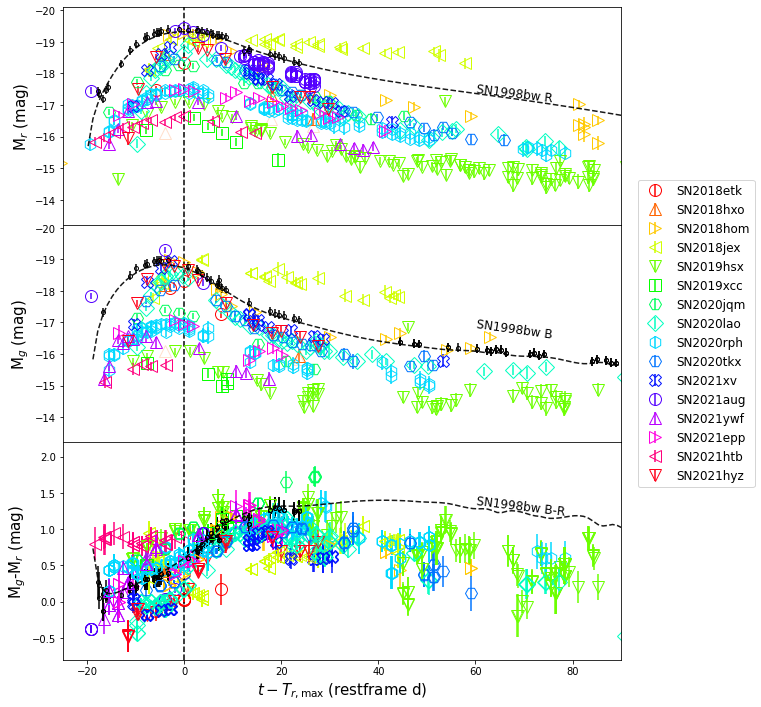

In [7]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1)
plt.subplots_adjust(wspace = 0, hspace = 0)
markerlist = ['o','^','>','<','v','s','H','D','h','H','X']

for i, ztfid in enumerate(snlist):
    cc = plt.get_cmap('hsv')(float(i)/(len(ztfpm.data)-1))
    mm = markerlist[i%len(markerlist)]
    iauid = ztfpm.data[ztfid].aliasid.replace('AT','SN')
    ztfpm.data[ztfid].ax2 = ax1
    ztfpm.data[ztfid]._ax2(
        plot_bands=['r'], color=cc, marker=mm, markersize=12, alphabest=1, label=iauid,
        show_fits=False, show_legend=False, show_gp=False, show_texp=False,
    )
    ztfpm.data[ztfid].ax2 = ax2
    ztfpm.data[ztfid]._ax2(
        plot_bands=['g'], color=cc, marker=mm, markersize=12, alphabest=1,
        show_fits=False, show_legend=False, show_gp=False, show_texp=False,
    )
    ztfpm.data[ztfid].ax3 = ax3
    ztfpm.data[ztfid]._ax3(
        color=cc, marker=mm, markersize=12, show_texp=False, ylabel_2right=False,
    )
    

# points
sn1998bw_df.ax2 = ax1
sn1998bw_df._ax2(
        plot_bands=['r'], color='k', marker='o', markersize=4, alphabest=1,
        show_fits=False, show_legend=False, show_gp=False, show_texp=False, label='',
    )
sn1998bw_df.ax2 = ax2
sn1998bw_df._ax2(
        plot_bands=['g'], color='k', marker='o', markersize=4, alphabest=1,
        show_fits=False, show_legend=False, show_gp=False, show_texp=False,
    )
sn1998bw_df.ax3 = ax3
sn1998bw_df._ax3(
        color='k', marker='o', markersize=4, show_texp=False, ylabel_2right=False,
    )

# GP
sn1998bw_df.gpcls.predict(x_pred=np.arange(sn1998bw_df.t0-40, sn1998bw_df.t0+130), clobber=True)
__ = np.where(sn1998bw_df.gpcls.f_pred=='r')
xx = sn1998bw_df.gpcls.x_pred[__]
pp = (xx-sn1998bw_df.t0) / (1+sn1998bw_df.z)
yy = sn1998bw_df.gpcls.y_pred[__]
mm1 = sn1998bw_df.flux_to_mag(yy, dflux=None)
ax1.plot( pp, mm1-sn1998bw_df.dm-.1, ls='--', marker='', color='k', alpha=.9, zorder=1000)

__ = np.where(sn1998bw_df.gpcls.f_pred=='g')
xx = sn1998bw_df.gpcls.x_pred[__]
pp = (xx-sn1998bw_df.t0) / (1+sn1998bw_df.z)
yy = sn1998bw_df.gpcls.y_pred[__]
mm2 = sn1998bw_df.flux_to_mag(yy, dflux=None)
ax2.plot( pp, mm2-sn1998bw_df.dm-.1, ls='--', marker='', color='k', alpha=.9, zorder=1000)
ax3.plot( pp, mm2-mm1, ls='--', marker='', color='k', alpha=.9, zorder=1000)

for ax in [ax1,ax2,ax3]: 
    ax.set_xlim([-25,90])
    ax.axvline(0,color='k',ls='--')
for ax in [ax1,ax2]: ax.set_ylim([-13.21,-20.1])
ax3.set_ylim([-.8,2.2])

ax1.text(60,-17.1,'SN1998bw R', fontsize=12, rotation=-7)
ax2.text(60,-16.5,'SN1998bw B', fontsize=12, rotation=-8)
ax3.text(60,1.2,'SN1998bw B-R', fontsize=12, rotation=-7)

ax1.set_xticks([])
ax2.set_xticks([])

ax1.legend(loc = 'center right', bbox_to_anchor = (1.25, -0.5), 
           ncol=1, numpoints=1, fontsize=12, frameon=True)
ax3.set_xlabel('$t - T_{r,\mathrm{max}} \; (\mathrm{restframe \; d})$',fontsize=15)
ax1.set_ylabel('$\mathrm{M}_r$ (mag)',fontsize=15)
ax2.set_ylabel('$\mathrm{M}_g$ (mag)',fontsize=15)
ax3.set_ylabel('$\mathrm{M}_g$-$\mathrm{M}_r$ (mag)',fontsize=15)

fig.set_size_inches(10,12)
plt.show()
fig.savefig('/Users/yash0613/Desktop/lcs_mag.png', bbox_inches='tight', dpi=400)

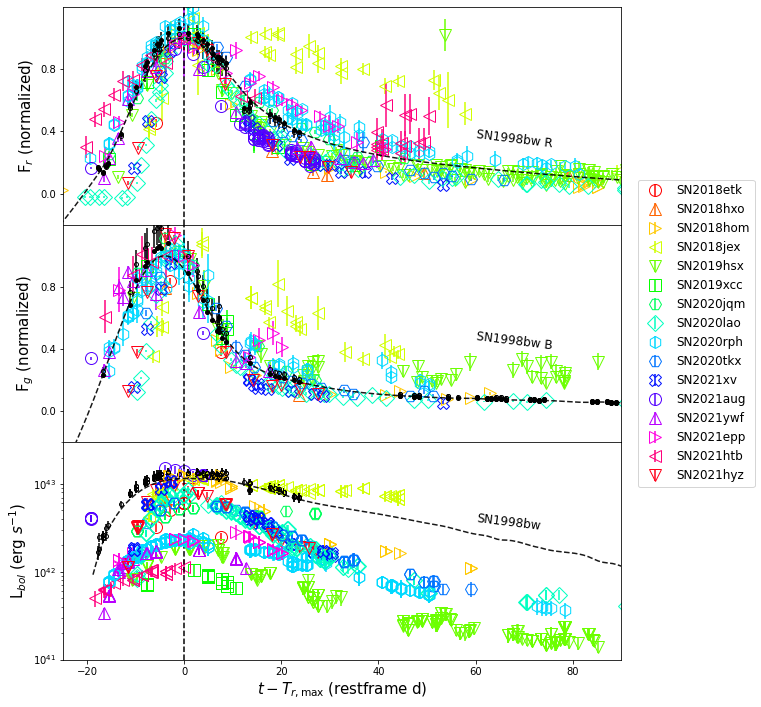

In [8]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1)
plt.subplots_adjust(wspace = 0, hspace = 0)
markerlist = ['o','^','>','<','v','s','H','D','h','H','X']

for i, ztfid in enumerate(snlist):
    cc = plt.get_cmap('hsv')(float(i)/(len(ztfpm.data)-1))
    mm = markerlist[i%len(markerlist)]
    iauid = ztfpm.data[ztfid].aliasid.replace('AT','SN')
    ztfpm.data[ztfid].ax = ax1
    ztfpm.data[ztfid]._ax(
        plot_bands=['r'], ax_xstyle='rp', flux_scale=1, yshift=0,
        color=cc, marker=mm,  markersize=12, alphabest=1, label=iauid,
        show_title=False, show_legend=True, ylabel_2right=False,
        show_data=True, show_fits=False, show_gp=False, show_fit_error=True,
        show_texp=False, interpolation=None, index=0, snr_thre=3,
    )
    ztfpm.data[ztfid].ax = ax2
    ztfpm.data[ztfid]._ax(
        plot_bands=['g'], ax_xstyle='rp', flux_scale=1, yshift=0,
        color=cc, marker=mm, markersize=12, alphabest=1, label=None,
        show_title=False, show_legend=False, ylabel_2right=False,
        show_data=True, show_fits=False, show_gp=False, show_fit_error=True,
        show_texp=False, interpolation=None, index=0, snr_thre=5,
    )
    ztfpm.data[ztfid].ax4 = ax3
    ztfpm.data[ztfid]._ax4(
        color=cc, marker=mm, markersize=12, show_texp=False, ylabel_2right=False,
    )


# points
sn1998bw_df.ax = ax1
sn1998bw_df._ax(
        plot_bands=['r'], ax_xstyle='rp', flux_scale=1, yshift=0,
        color='k', marker='o',  markersize=4, alphabest=1, label='',
        show_title=False, show_legend=False, ylabel_2right=False,
        show_data=True, show_fits=False, show_gp=False, show_fit_error=True,
        show_texp=False, interpolation=None, index=0, 
    )
sn1998bw_df.ax = ax2
sn1998bw_df._ax(
        plot_bands=['g'], ax_xstyle='rp', flux_scale=1, yshift=0,
        color='k', marker='o', markersize=4, alphabest=1, 
        show_title=False, show_legend=False, ylabel_2right=False,
        show_data=True, show_fits=False, show_gp=False, show_fit_error=True,
        show_texp=False, interpolation=None, index=0, 
    )
sn1998bw_df.ax4 = ax3
sn1998bw_df._ax4(
        color='k', marker='o', markersize=4, show_texp=False, ylabel_2right=False,
    )

t0 = sn1998bw_df.t0
z = sn1998bw_df.z
dm = sn1998bw_df.dm
sn1998bw_df.gpcls.predict(x_pred=np.arange(t0-40, t0+130), clobber=True)
for filt, ax in zip(['r', 'g'], [ax1, ax2]):
    _lc=sn1998bw_df.lc.query('filter==@filt and mag<99')
    __ = np.where(sn1998bw_df.gpcls.f_pred==filt)
    xx = sn1998bw_df.gpcls.x_pred[__]
    pp = (xx-t0) / (1+z)
    yy = sn1998bw_df.gpcls.y_pred[__]
    ax.errorbar( (_lc['jdobs']-t0)/(1+z), _lc['flux']/max(yy), 
                 yerr=_lc['emag']/max(yy), ls='',
                 marker='o', markersize=4, color='k')
    ax.plot( pp, yy/max(yy), ls='--', marker='', color='k', alpha=.9, zorder=1000)

# GP
__ = np.where(sn1998bw_df.gpcls.f_pred=='r')
xx = sn1998bw_df.gpcls.x_pred[__]
pp = (xx-t0) / (1+z)
yy = sn1998bw_df.gpcls.y_pred[__]
mm1 = sn1998bw_df.flux_to_mag(yy, dflux=None)
__ = np.where(sn1998bw_df.gpcls.f_pred=='g')
yy = sn1998bw_df.gpcls.y_pred[__]
mm2 = sn1998bw_df.flux_to_mag(yy, dflux=None)
bc, _ = functions.BC_Lyman(mm2-mm1, colortype='g-r', phase='normal', sntype='Ic-BL')
mbol = bc + mm2 - dm     
Lbol = functions.Mbol_to_Lbol(mbol)                        
_=np.isfinite(Lbol)    
ax3.plot( pp[_], Lbol[_], ls='--', marker='', color='k', alpha=.9, zorder=1000)

#
for ax in [ax1,ax2,ax3]: 
    ax.set_xlim([-25,90])
    ax.axvline(0,color='k',ls='--')
for ax in [ax1,ax2]: 
    ax.set_ylim([-.2,1.2])
    ax.set_yticks([0,.4,.8])
ax3.set_ylim([1e41,3e43])

ax1.text(60,.3,'SN1998bw R', fontsize=12, rotation=-7)
ax2.text(60,.4,'SN1998bw B', fontsize=12, rotation=-7)
ax3.text(60,3e42,'SN1998bw', fontsize=12, rotation=-7)

ax1.set_xticks([])
ax2.set_xticks([])

ax1.legend(loc = 'center right', bbox_to_anchor = (1.25, -0.5), 
           ncol=1, numpoints=1, fontsize=12, frameon=True)
ax3.set_xlabel('$t - T_{r,\mathrm{max}} \; (\mathrm{restframe \; d})$',fontsize=15)
ax1.set_ylabel('$\mathrm{F}_r$ (normalized)',fontsize=15)
ax2.set_ylabel('$\mathrm{F}_g$ (normalized)',fontsize=15)
ax3.set_ylabel('$\mathrm{L}_{bol}$ (erg $s^{-1}$)',fontsize=15)
ax3.set_yscale('log')

fig.set_size_inches(10,12)
plt.show()
fig.savefig('/Users/yash0613/Desktop/lcs_flux.png', bbox_inches='tight', dpi=400)

In [12]:
ztfpm.add_subset()
ztfpm.pars=[]
ztfpm.add_parameter(parname='aliasid')
ztfpm.add_parameter(parname='objid')
ztfpm.add_parameter(parname='tpeak', filt1='r')
ztfpm.add_parameter(parname='Mag', filt1='r', phase1=0)
ztfpm.add_parameter(parname='Mag', filt1='g', phase1=0)
ztfpm.add_parameter(parname='texp', expwith='bol')
ztfpm.add_parameter(parname='mni')
ztfpm.add_parameter(parname='taum')
tab = ztfpm.table(syntax=None, tablename=None)
print (tab)

aliasid & objid & tpeak_GP_r & Mag_r_0 & Mag_g_0 & texp_bol & mni & taum \\ 
SN2021aug & ZTF21aafnunh & 2459252.727 & -19.433 (0.095) & -19.013 (0.132) & -16.355$_{-0.183}^{0.366}$ & 0.611$_{-0.013}^{0.015}$ & 11.312$_{-0.456}^{0.651}$ \\ 
SN2018hom & ZTF18acbwxcc & 2458426.806 & -19.293 (0.108) & -18.908 (0.099) & -9.303$_{-0.358}^{0.701}$ & 0.417$_{-0.005}^{0.006}$ & 6.93$_{-0.201}^{0.144}$ \\ 
SN2021xv & ZTF21aadatfg & 2459236.033 & -18.922 (0.113) & -18.985 (0.112) & -12.854$_{-0.108}^{0.217}$ & 0.325$_{-0.004}^{0.003}$ & 7.921$_{-0.147}^{0.107}$ \\ 
SN2021hyz & ZTF21aartgiv & 2459319.813 & -18.826 (0.111) & -18.666 (0.098) & -13.597$_{-0.112}^{0.201}$ & 0.309$_{-0.004}^{0.005}$ & 8.228$_{-0.14}^{0.227}$ \\ 
SN2020lao & ZTF20abbplei & 2459004.953 & -18.654 (0.096) & -18.485 (0.099) & -11.528$_{-0.05}^{0.098}$ & 0.263$_{-0.002}^{0.001}$ & 8.139$_{-0.066}^{0.061}$ \\ 
SN2018hxo & ZTF18acaimrb & 2458404.812 & -18.706 (0.128) & -18.435 (0.157) & -9784199691.871$_{-10930606313.706}^{205

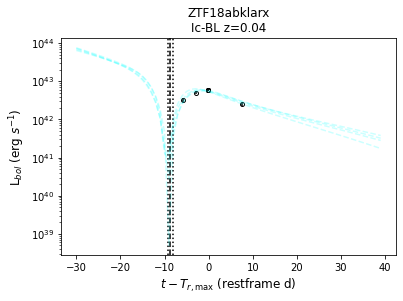

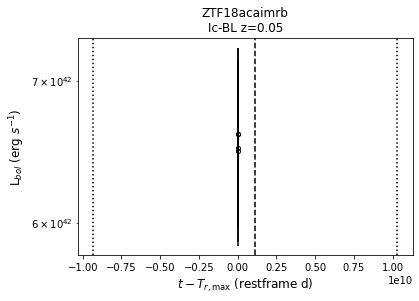

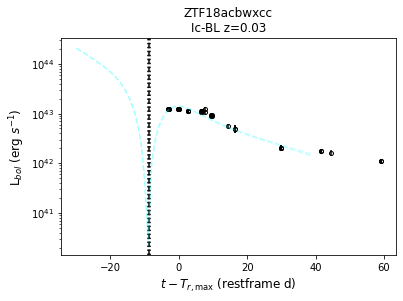

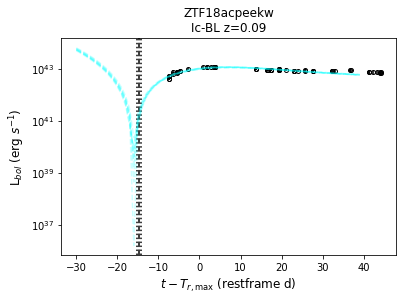

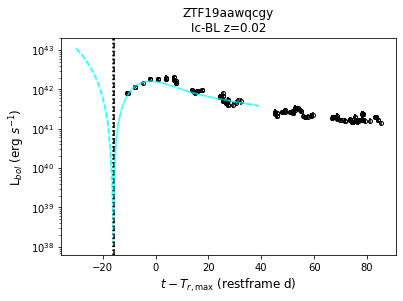

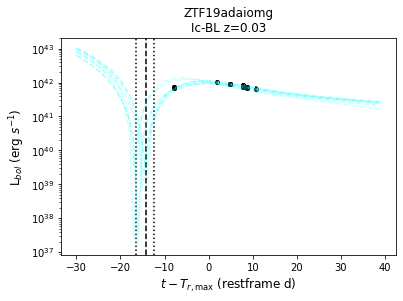

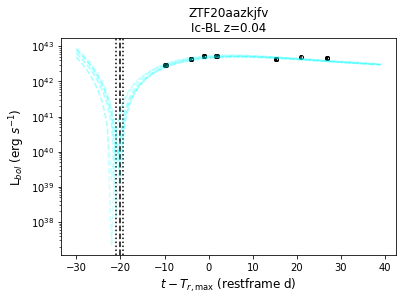

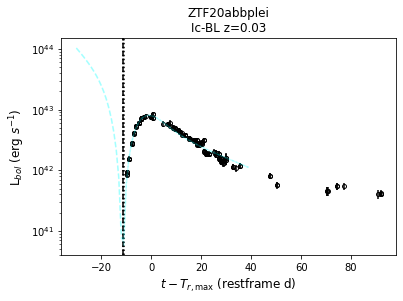

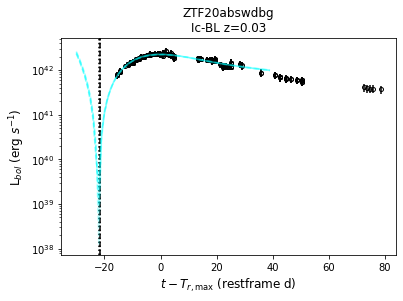

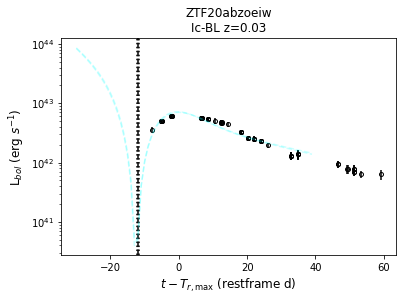

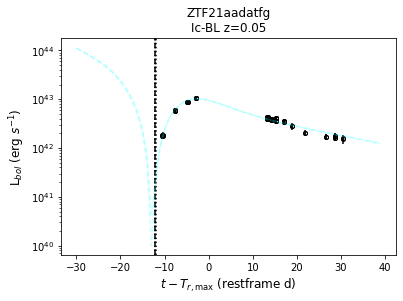

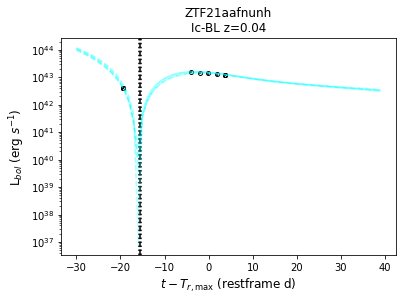

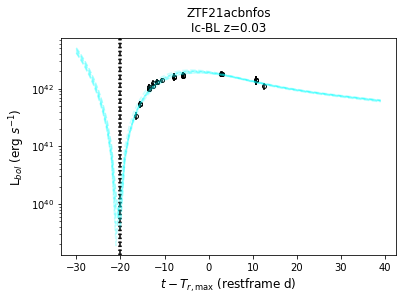

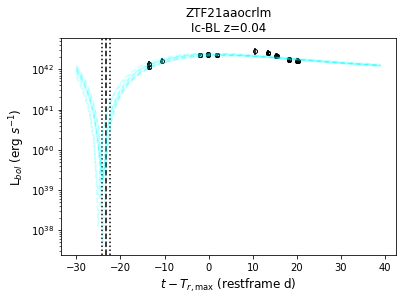

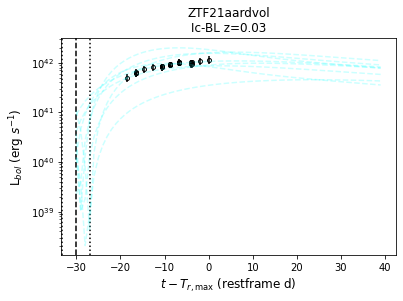

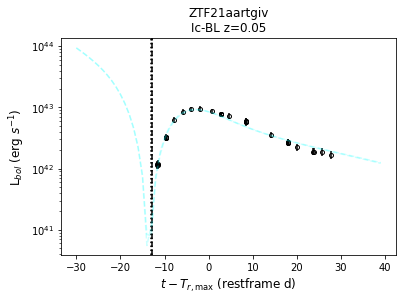

In [13]:
for ztfid in snlist:
    fig,ax=plt.subplots(1,1)
    ztfpm.data[ztfid].ax4 = ax
    ztfpm.data[ztfid]._ax4(make_bol=['lyman'], show_fits=True, show_title=True)